## **Ouliers detection**

*Observation which deviates so much from other observations as to arouse suspicion it was generated by a different mechanism*<br>
*--- Hawkings (1980)*

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an **outlier is an observation that diverges from an overall pattern on a sample.** Outliers can be of two kinds: univariate and multivariate. Univariate outliers can be found when looking at a distribution of values in a single feature space. Multivariate outliers can be found in a n-dimensional space (of n-features). Looking at distributions in n-dimensional spaces can be very difficult for the human brain, that is why we need to train a model to do it for us.

Outliers can also come in different flavours, depending on the environment: point outliers, contextual outliers, or collective outliers. Point outliers are single data points that lay far from the rest of the distribution. Contextual outliers can be noise in data, such as punctuation symbols when realizing text analysis or background noise signal when doing speech recognition. Collective outliers can be subsets of novelties in data such as a signal that may indicate the discovery of new phenomena.

In the process of producing, collecting, processing and analyzing data, outliers can come from many sources and hide in many dimensions. Those that are not a product of an error are called **novelties**. Detecting outliers is of major importance for almost any quantitative discipline (ie: Physics, Economy, Finance, Machine Learning, Cyber Security). In machine learning and in any quantitative discipline the quality of data is as important as the quality of a prediction or classification model.

### Outliers on this Dataset
Considering that the data follows Gaussian-like distribution. If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers. The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

So, if the mean is 28.2 and the standard deviation is 6.5 for module 34.B2.9F.A9, then all data in the sample between 34.7 and 21.7 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows: 1 Standard Deviation from the Mean: 68% ;2 Standard Deviations from the Mean: 95%; 3 Standard Deviations from the Mean: 99.7, 3.5 STD from Mean 99.9%.

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples. Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

*Given mu and sigma, a simple way to identify outliers is to compute a z-score for every xi, which is defined as the number of standard deviations away xi is from the mean […] Data values that have a z-score sigma greater than a threshold, for example, of three, are declared to be outliers.*

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots. On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots. We can calculate the percentiles of a dataset using the `percentile()` NumPy function that takes the dataset and specification of the desired percentile. The IQR can then be calculated as the difference between the 75th and 25th percentiles.

These methods aren't very accurate, cause they don't discriminate between outliers and novelties, in order to do so is needed a better anomaly detection method.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates
from time import time
import scipy.io

# custom module anomalies.py
# module with all the functions related to anomalies
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import anomalies as anm

# for anomalies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import model_from_json

In [49]:
## Managing Modules
from importlib.util import find_spec
if find_spec("utils") is None:
    import sys
    sys.path.append('..')

# custom lib
import helper_functions as hf
# Usefull when importing modules in notebooks
from utils import column_names, colors, moving_average, remove_chart_borders

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
pd.set_option('max_columns',40, 'precision',4)

Modules={"00.57.FE.04":'Net-Coordinator',
         "00.57.FE.0E":'Radio-2.4 GHz',
         "00.57.FE.0F":'Radio-2.4 GHz',
         "00.57.FE.06":'Radio-2.4 GHz',
         "00.57.FE.09":'Radio-2.4 GHz',
         "00.57.FE.01":'Radio-2.4 GHz',
         "00.57.FE.05":'Radio-2.4 GHz',
         "00.57.FE.03":'Radio-2.4 GHz',
         "29.E5.5A.24":'Acq-Tempe',
         "A7.CB.0A.C0":'Acq-Current/Volt',
         "34.B2.9F.A9":'P-Solar Panel',
         "01.E9.39.32":'Acq-Current/Volt',
         "A4.0D.82.38":'P-AC/DC Input',
         "9F.8D.AC.91":'Acq-Tempe',
         "50.39.E2.80":'P-Solar Panel'}

column_names=['Timestamp','Module','Type','Temp_Mod', 'VBus',
              'PT100(0)', 'PT100(1)', 'LVL_Dim(1)', 'V_MPPT',
              'V_Panel','LVL_Drain(1)','VBat', 'V_Supp','Temp_Oil',
              'Temp_gab','V_MPPT_TE','V_Panel_TE']

In [37]:
# define colors
colors = {'GRAY1':'#231F20', 'GRAY2':'#414040', 'GRAY3':'#555655',
         'GRAY4':'#646369', 'GRAY5':'#76787B', 'GRAY6':'#828282',
         'GRAY7':'#929497', 'GRAY8':'#A6A6A5', 'GRAY9':'#BFBEBE',
         'BLUE1':'#174A7E', 'BLUE2':'#4A81BF', 'BLUE3':'#94B2D7',
         'BLUE4':'#94AFC5', 'RED1':'#C3514E', 'RED2':'#E6BAB7',
         'GREEN1':'#0C8040', 'GREEN2':'#9ABB59', 'ORANGE1':'#F79747',}

In [3]:
# Loading the data
df = pd.read_csv('../../Features.csv', usecols=column_names, parse_dates=['Timestamp'], infer_datetime_format=True)
df = anm.add_date_features(df)
df.head()

D:\Repositories\Wireless_Sensor_Network\Notebooks\anomalies.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['Timestamp'].dt.week


,Module,Type,Temp_Mod,VBus,PT100(0),PT100(1),LVL_Dim(1),V_MPPT,V_Panel,LVL_Drain(1),VBat,V_Supp,Temp_Oil,Temp_gab,V_MPPT_TE,V_Panel_TE,hour,day,month,week,weekday,daylight
Timestamp,,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:05,00.57.FE.04,Net-Coordinator,25.3,4.736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0
2017-10-01 00:00:42,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0
2017-10-01 00:01:13,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0
2017-10-01 00:01:42,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0
2017-10-01 00:02:05,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0


In [4]:
df2 = df.copy()
df2.reset_index(inplace=True)
df_outliers, df2 = anm.get_outliers(df2, Modules, std_times=3, verbose=False, remove=True)

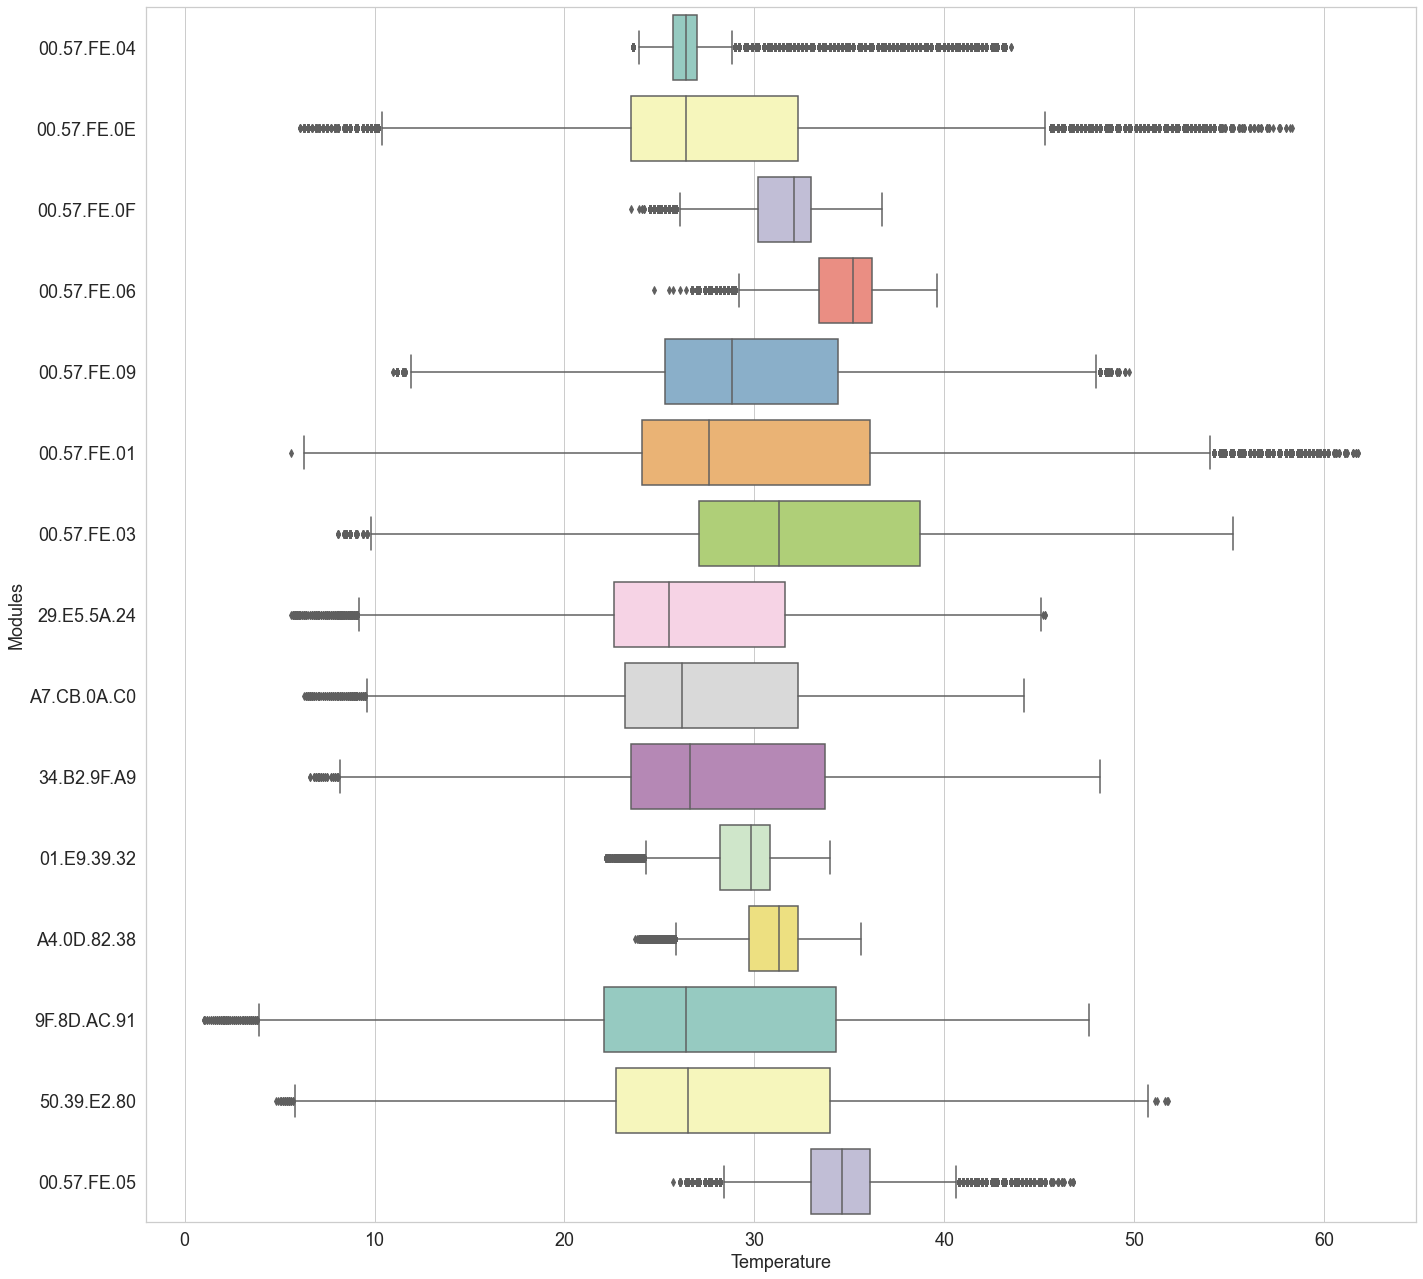

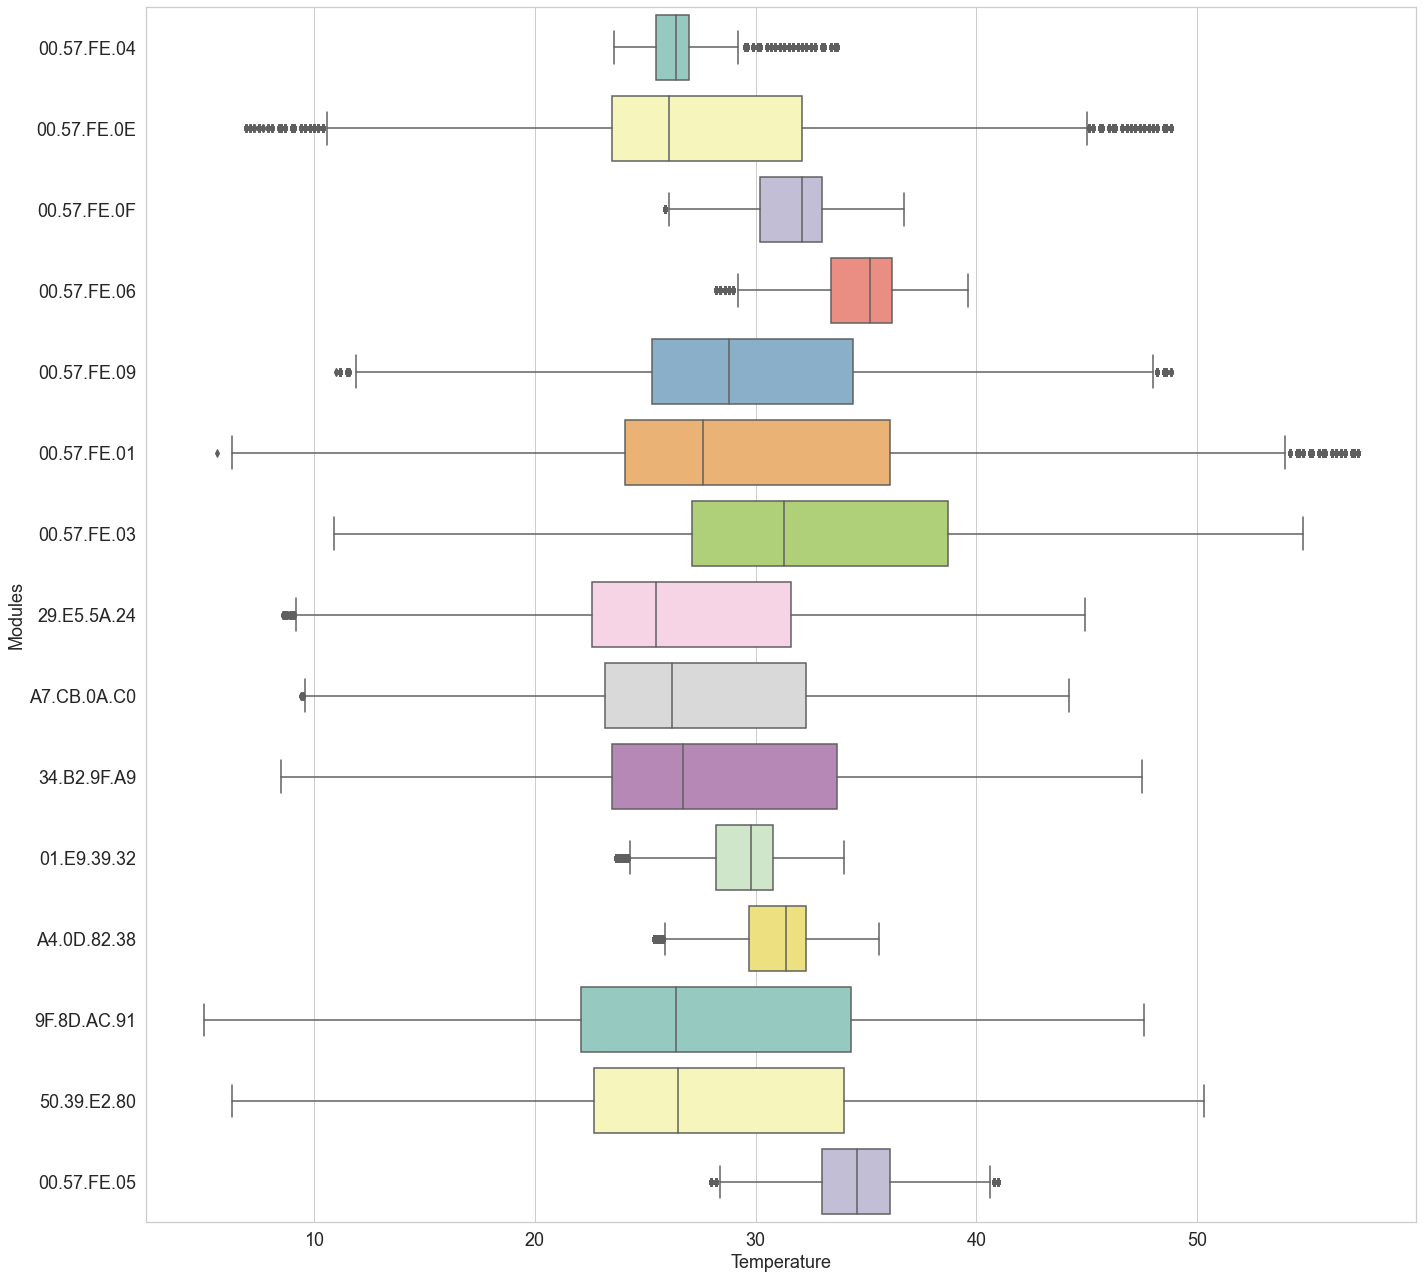

In [18]:
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
fig = plt.figure(figsize=(20,18))
#plt.title('Box Plot of Temperatures by Modules with outliers')
sns.boxplot(y='Module',x='Temp_Mod',data=df, palette='Set3')
plt.xlabel('Temperature',fontsize=18)
plt.ylabel('Modules',fontsize=18)
plt.tight_layout()
fig.savefig('../images/BoxPlotofTemperaturesbyModuleswithoutliers.pdf', dpi=300)

fig = plt.figure(figsize=(20,18))
#plt.title('Box Plot of Tmperatures by Modules with outliers Removed')
sns.boxplot(y='Module',x='Temp_Mod',data=df2, palette='Set3', fliersize=5)
plt.xlabel('Temperature',fontsize=18)
plt.ylabel('Modules',fontsize=18)
plt.tight_layout()
fig.savefig('../images/BoxPlotofTemperaturesbyModuleswithoutOutliers.pdf', dpi=300)

We can see that a considerably amounth of outliers was removed, now, there is no ensurance that all this data were in fact outliers. Therefor, a more accurate method of detection of outliers must be implemented. If we make a `pd.describe()` we can see the amounth of possible outliers by module

In [13]:
df_outliers.describe().loc[['count']]

,00.57.FE.04,00.57.FE.0E,00.57.FE.0F,00.57.FE.06,00.57.FE.09,00.57.FE.01,00.57.FE.05,00.57.FE.03,29.E5.5A.24,A7.CB.0A.C0,34.B2.9F.A9,01.E9.39.32,A4.0D.82.38,9F.8D.AC.91,50.39.E2.80
count,65532.0,3288.0,1796.0,2014.0,19.0,931.0,3306.0,233.0,240.0,167.0,53.0,742.0,622.0,194.0,48.0


In [22]:
# Locate entry with some outliers
slice_of_data= df[df['Module']== '34.B2.9F.A9']
slice_of_data = slice_of_data.dropna(axis=1, how='all')
slice_of_data[slice_of_data['Temp_Mod']==df_outliers['34.B2.9F.A9'][10]]

,Module,Type,Temp_Mod,VBus,V_MPPT,V_Panel,hour,day,month,week,weekday,daylight
Timestamp,,,,,,,,,,,,
2019-07-07 05:58:44,34.B2.9F.A9,P-Solar Panel,7.9,3.266,3.268,0.000,5,7,7,27,6,0
2019-07-07 06:03:57,34.B2.9F.A9,P-Solar Panel,7.9,3.254,3.259,0.000,6,7,7,27,6,0
2019-07-07 11:08:56,34.B2.9F.A9,P-Solar Panel,7.9,3.236,3.237,15.745,11,7,7,27,6,1


Above is an example of possible outliers detected in the original dataset. The temperature of 7.9 degrees is considered an outlier in module 34.B2.9F.A9, but we can see that in 2 cases this temperature correspond to a Voltage Panel of 0 Volts, meaning there was no Sun, also, the timestamp indicates that it was early in the morning and all values are in the same day, therefor, there is a possibility that this is a valid value, and also, all the points in the vecinity are close to this value so the possibility is that it was just a very cold day. <br>
This are **collective outliers**. The 3rd example does looks suspicious, since the Panel was generating good voltage (15 Volts) and it was almost noon. But, wee saw that there is some correlation between this features (V_Panel and Temperature). This is why is needed a stronger method for outlier detection.

A safe bet also is to use wisdom of the crowds by using multiple ensemble methods. We can then choose to combine them through majority vote, or union or intersection of the individual algorithms’ verdicts.

### **Trying other methods for anomaly detection**

Conventional statistical methods are generally more interpretable and sometimes more useful than machine learning-based methods, depending on the specified problem. Some are Holt-Winters(Triple Exponential Smoothing), ARIMA (Auto-Regressive Integrated Moving Average) and Histogram-Based Outlier Detection (HBOS).

Machine Learning methods can model more complex data and hence able to detect more complex anomalies than conventional statistical methods. Thety can be Supervised (e.g. Decision Tree, SVM, LSTM Forecasting), Unsupervised (e.g. K-Means, Hierarchical Clustering, DBSCAN, Isolation Forest), Self-Supervised (e.g. LSTM Autoencoder) and the data represented in Points, Rolling Window (or trajectory matrix) or Time Series Features (transformations, decompositions and statistical measurements).

So i'm going to try out some Machine leatning methods using and use the **Wisdom of the crowds** thinking. Also, since i don't know where are the nomalies, this is a problem of unsupervised learning, so i will consider that there are a small fraction of anomalies and the majority of the data is correct.


## K-Means and PCA for collective anomalies

We group together the usual combination of features. The points that are far from the cluster are points with unusual combination of features. We consider those points as anomalies.<br>
**Results:**<br>

Tried with 20 clusters the firts time and the method takes to long to separate the data and then to get the distance from every point (more than 2 hours and only with module 04).<br>
The algorithm recognizes anomalies in the center values, but is not good for anomalies in the extremes.
**The experiment can be seen in master/Outliers_Detection/Outliers_Detection.ipynb**

## Gaussian for unordered collective anomalies

First i will do it for a single feature. The outliers fraction is still a small number.<br>
**Results**<br>
The algorithm recognizes anomalies in the higher values but takes very few from small ones. In contrast with K-Means the algorithm is very fast.

In [23]:
# Here taking only one module
slice_of_data = df[df['Module']== '00.57.FE.0E'].dropna(axis=1, how='all')
#slice_of_data.head()

In [24]:
outliers_fraction = 0.02

In [25]:
# apply ellipticEnvelope (gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = slice_of_data['Temp_Mod'].values.reshape(-1,1)
print(envelope.fit(X_train),'\n')
slice_of_data['deviation'] = envelope.decision_function(X_train)
slice_of_data['anomaly_Gaussian'] = envelope.predict(X_train)
slice_of_data.head()

EllipticEnvelope(contamination=0.02) 



,Module,Type,Temp_Mod,VBus,hour,day,month,week,weekday,daylight,deviation,anomaly_Gaussian
Timestamp,,,,,,,,,,,,
2017-10-01 00:00:34,00.57.FE.0E,Radio-2.4 GHz,20.1,3.296,0,1,10,39,6,0,12.4298,1
2017-10-01 00:02:34,00.57.FE.0E,Radio-2.4 GHz,19.9,3.296,0,1,10,39,6,0,12.3309,1
2017-10-01 00:04:30,00.57.FE.0E,Radio-2.4 GHz,19.9,3.296,0,1,10,39,6,0,12.3309,1
2017-10-01 00:06:30,00.57.FE.0E,Radio-2.4 GHz,19.9,3.296,0,1,10,39,6,0,12.3309,1
2017-10-01 00:08:30,00.57.FE.0E,Radio-2.4 GHz,20.1,3.296,0,1,10,39,6,0,12.4298,1


In [26]:
slice_of_data.reset_index(inplace=True)  # this is only to allow use loc, will set timestamp later
# anomalies marked as -1
anomaly = slice_of_data.loc[slice_of_data['anomaly_Gaussian'] == -1, ['Timestamp', 'Temp_Mod']] #anomaly
slice_of_data.set_index('Timestamp',inplace=True, drop=True) 

In [27]:
from matplotlib import gridspec

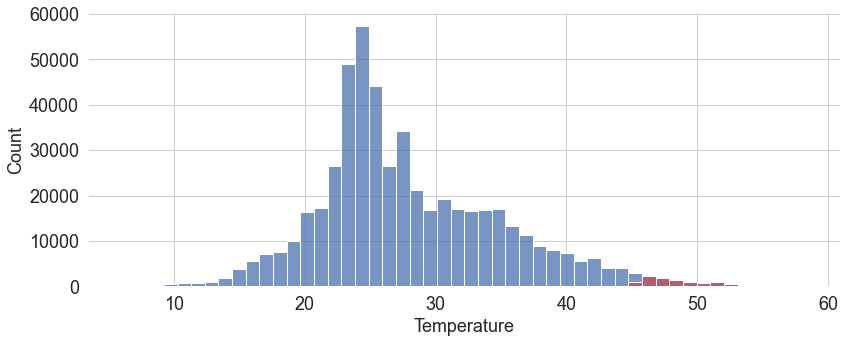

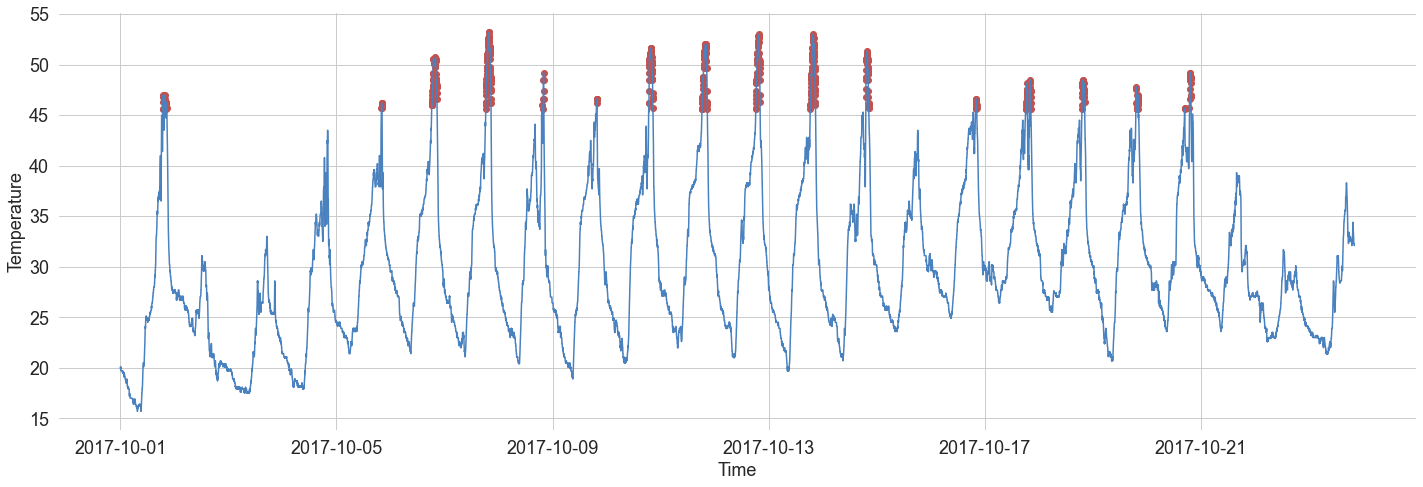

In [54]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,5))

sns.histplot(data=slice_of_data['Temp_Mod'], kde=False, ax=ax1, bins=50)
sns.histplot(data=anomaly['Temp_Mod'], kde=False, color='r', ax=ax1, bins=50)
ax1.set_ylabel('Count', fontsize=18)
ax1.set_xlabel('Temperature', fontsize=18)
remove_chart_borders(ax1)
plt.tight_layout()
fig.savefig('../images/gaussianAnomalyHist.pdf', dpi=300)

fig, (ax2) = plt.subplots(1, 1, figsize=(20,7))
ax2.plot(slice_of_data.index[:16000], slice_of_data['Temp_Mod'][:16000], color=colors['BLUE2'])
ax2.scatter(anomaly['Timestamp'][:570],anomaly['Temp_Mod'][:570], color=colors['RED1'])
ax2.set_ylabel('Temperature', fontsize=18)
ax2.set_xlabel('Time', fontsize=18)
plt.tight_layout()
remove_chart_borders(ax2)
fig.savefig('../images/gaussianAnomaly.pdf', dpi=300)

In [55]:
outliers_fraction = 0.01
final_date='2019-01-20 00:00:05'
split_date = '2018-11-01 00:00:05'
test_date = '2019-01-16 00:00:05'
resample_time = '5Min'

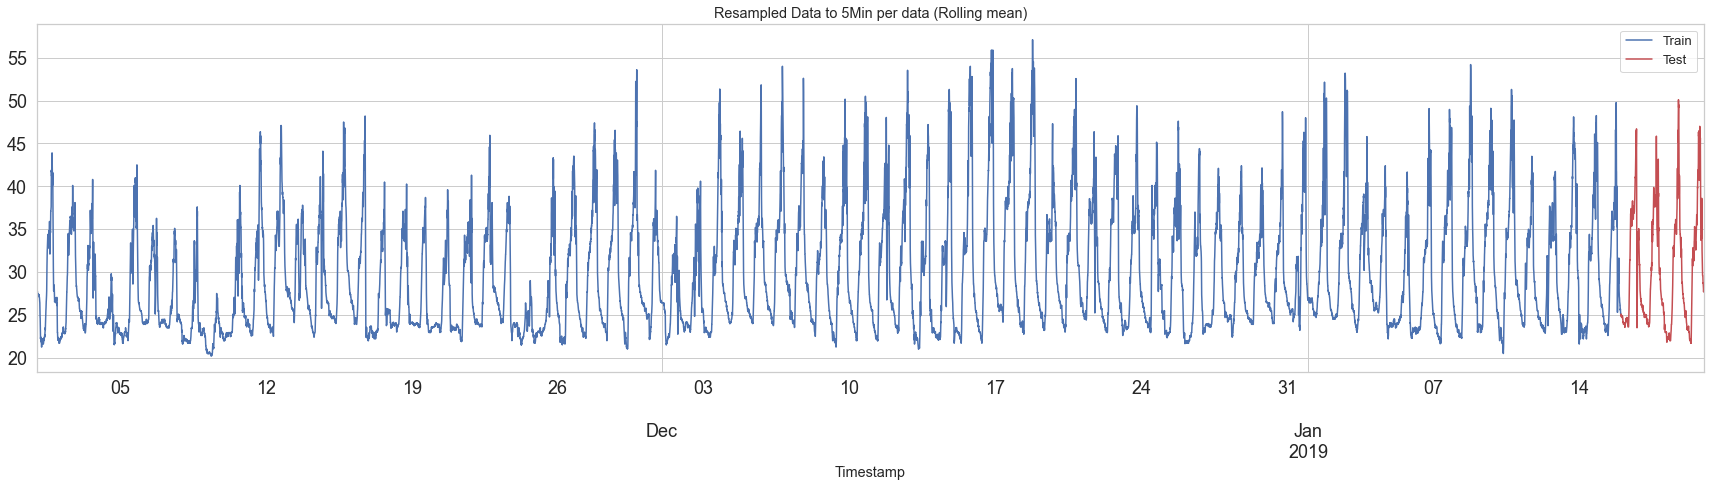

In [57]:
# Splitting by date, saving a part for testing
data, train_data, test_data, X_train,X_test, y_train, y_test, scaler = anm.create_train_test(slice_of_data, final_date=final_date,
                                                                                             split_date=split_date, test_date=test_date,
                                                                                             resample_time=resample_time, figsize=(24,7),
                                                                                             scaler=MinMaxScaler())

In [106]:
data

,Temp_Mod,VBus,hour,day,month,week,weekday,daylight,deviation,anomaly_Gaussian,scores_isolation_f,anomaly_IsolationF,anomaly_SVM
Timestamp,,,,,,,,,,,,,
2018-11-01 00:05:00,28.5000,3.2660,0.0,1.0,11.0,44.0,3.0,0.0,13.7755,1.0,0.1722,0,0
2018-11-01 00:10:00,28.4000,3.2667,0.0,1.0,11.0,44.0,3.0,0.0,13.7922,1.0,0.1718,0,0
2018-11-01 00:15:00,28.4000,3.2660,0.0,1.0,11.0,44.0,3.0,0.0,13.7922,1.0,0.1718,0,0
2018-11-01 00:20:00,28.2667,3.2680,0.0,1.0,11.0,44.0,3.0,0.0,13.8112,1.0,0.1713,0,0
2018-11-01 00:25:00,28.2000,3.2640,0.0,1.0,11.0,44.0,3.0,0.0,13.8208,1.0,0.1719,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-19 23:40:00,28.0000,3.2660,23.0,19.0,1.0,3.0,5.0,0.0,13.8494,1.0,0.0953,0,0
2019-01-19 23:45:00,27.9000,3.2667,23.0,19.0,1.0,3.0,5.0,0.0,13.8610,1.0,0.0961,0,0
2019-01-19 23:50:00,27.7000,3.2660,23.0,19.0,1.0,3.0,5.0,0.0,13.8842,1.0,0.0953,0,0


**The elliptical envelope method has a good detection of extreme values.**

After trying Gaussian method, let's try three other different algorithms for anomaly detection.

## Isolation Forest for collective anomalies (unordered).

Isolation forest is a machine learning algorithm for anomaly detection. It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.

Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In general the first step to anomaly detection is to construct a profile of what's "normal", and then report anything that cannot be considered normal as anomalous. However, the isolation forest algorithm does not work on this principle; it does not first define "normal" behavior, and it does not calculate point-based distances. The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

Isolation Forest recursively generates partitions on the dataset by randomly selecting a feature and then randomly selecting a split value for the feature. Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

*Using Isolation Forest, we can not only detect anomalies faster but we also require less memory compared to other algorithms.*

Let's first split the dataset, we are not going to use all the data, there is no need to

In [78]:
data, anomaly_Iforest = anm.isolation_forest(data, n_estimators=50, outliers_fraction=0.01, scaler=MinMaxScaler())
print(anomaly_Iforest.describe().transpose())

          count     mean     std   min      25%      50%   75%   max
Temp_Mod  231.0  49.7248  2.8874  40.7  47.2833  49.4667  52.0  57.1


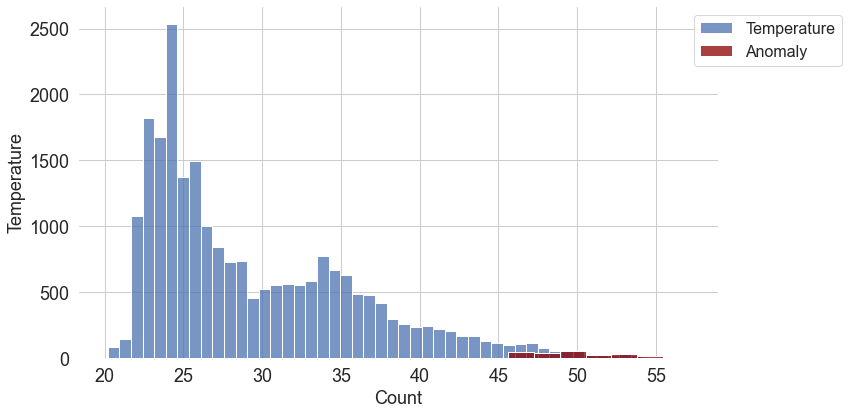

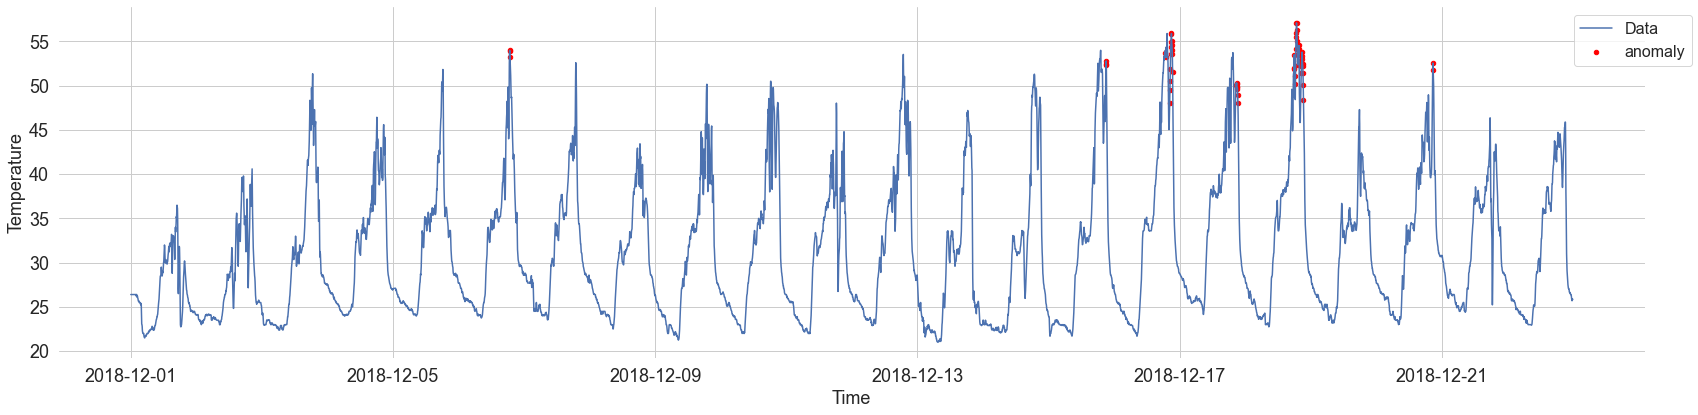

In [112]:
#anm.plot_anomalies_model(data, test_date, anomaly_Iforest, select='others')

fig, ax0 = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x=data['Temp_Mod'], kde=False, ax=ax0, bins=50, label='Temperature')
sns.histplot(x=anomaly_Iforest['Temp_Mod'], kde=False, color='darkred', ax=ax0, bins=10, label='Anomaly')
remove_chart_borders(ax0)
ax0.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.xlabel('Count', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/IForestHistogram.pdf', dpi=300)

fig, ax1 = plt.subplots(1, 1, figsize=(24, 6))
ax1.plot(data['2018-12-01':'2018-12-22'].index, data['Temp_Mod']['2018-12-01':'2018-12-22'], label='Data')
ax1.scatter(anomaly_Iforest['2018-12-01':'2018-12-22'].index, anomaly_Iforest['Temp_Mod']['2018-12-01':'2018-12-22'], color='red', s=20, label='anomaly')
remove_chart_borders(ax1)
ax1.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/IForestAnomalies.pdf', dpi=300)

In [99]:
data, anomaly_svm = anm.oneClass_SVM(data, nu=0.95, outliers_fraction=0.01, scaler=MinMaxScaler())
print(anomaly_svm.describe().transpose())

          count     mean      std   min   25%    50%    75%   max
Temp_Mod  218.0  38.2245  12.1796  21.7  25.5  40.55  49.05  57.1


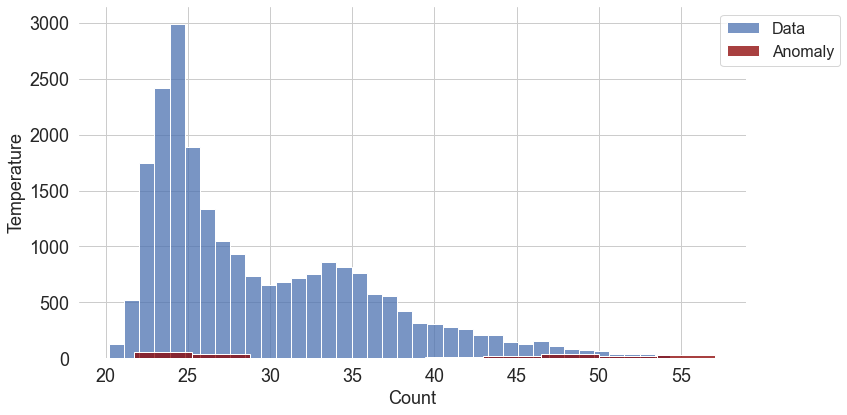

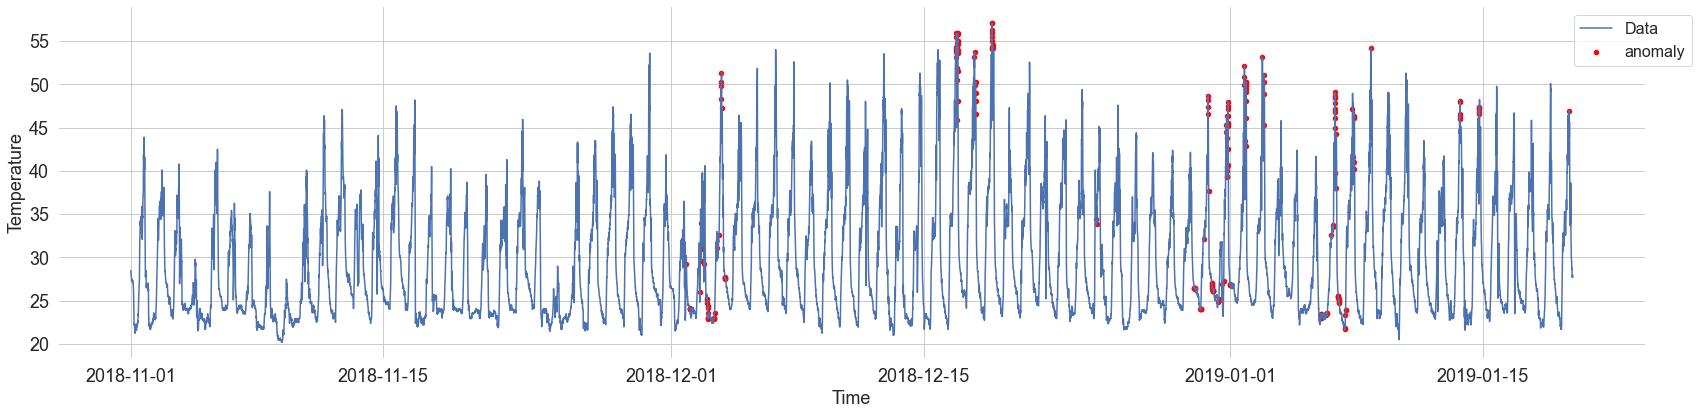

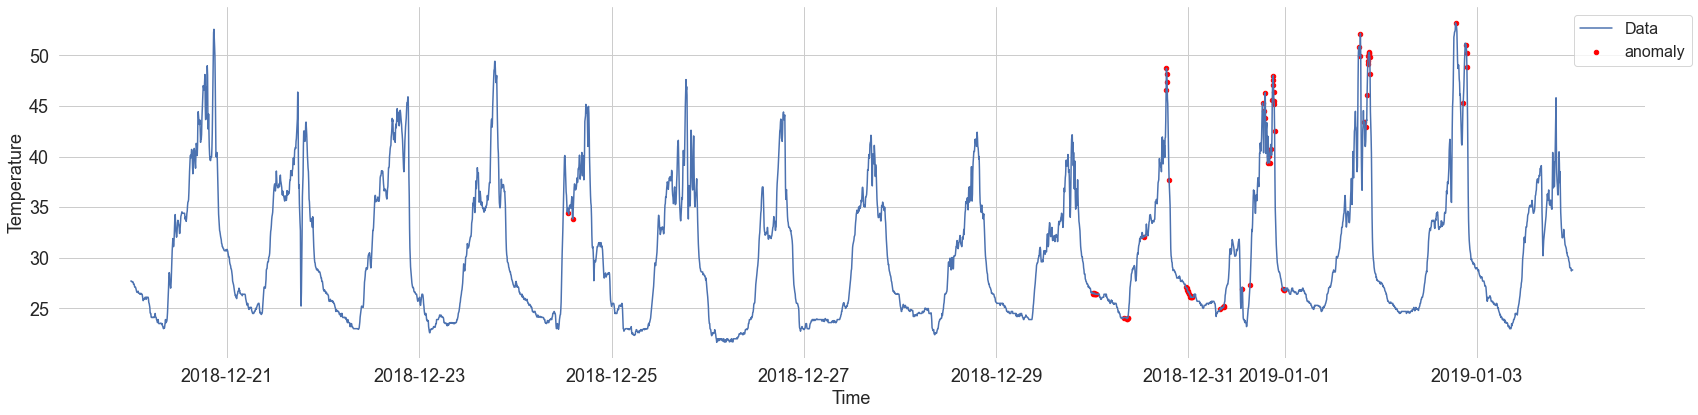

In [113]:
#anm.plot_anomalies_model(data, test_date, anomaly_Iforest, select='others')

fig, ax0 = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x=data['Temp_Mod'], kde=False, ax=ax0, bins=40, label='Data')
sns.histplot(x=anomaly_svm['Temp_Mod'], kde=False, color='darkred', ax=ax0, bins=10, label='Anomaly')
remove_chart_borders(ax0)
ax0.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.xlabel('Count', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/SVMHistogram.pdf', dpi=300)

fig, ax1 = plt.subplots(1, 1, figsize=(24, 6))
ax1.plot(data.index, data['Temp_Mod'], label='Data')
ax1.scatter(anomaly_svm.index, anomaly_svm['Temp_Mod'], color='red', s=20, label='anomaly')
remove_chart_borders(ax1)
ax1.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/SVMAnomalies.pdf', dpi=300)

fig, ax1 = plt.subplots(1, 1, figsize=(24, 6))
ax1.plot(data['2018-12-20':'2019-01-03'].index, data['Temp_Mod']['2018-12-20':'2019-01-03'], label='Data')
ax1.scatter(anomaly_svm['2018-12-20':'2019-01-03'].index, anomaly_svm['Temp_Mod']['2018-12-20':'2019-01-03'], color='red', s=20, label='anomaly')
remove_chart_borders(ax1)
ax1.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/SVMZoomedAnomalies.pdf', dpi=300)

## LSTM with multivariate features for  sequential anomalies (ordered)

The basic idea of anomaly detection with LSTM neural network is this: the system looks at the previous values over hours or days and predicts the behavior for the next minute. If the actual value a minute later is within, let’s say, one standard deviation, then there is no problem. If it is more it is an anomaly.

LSTM is used to look for anomalies in a period of time, but not in the entire dataset, although it can be runned over different parts of the dataset. These types of networks excel at finding complex relationships in multivariate time series data. 

The system looks to the trends of the Temperature, Voltage, day, hour, daylight, month and 2 more features in the case of sensors. We have acces to 2 years of data, which is a lot of data. Sicne LSTM looks at previous values in timesteps, i'll chose four different tensor configurations: 16, 32, 64, and 128-time steps with non overlapping windows and try different network configurations.

As said before, i have 26 months of samples, but to predict, let's say, the next 2 days i don't need to look at the past 2 years, instead i will start with 14 days in the past, then 10, then 7 days. The dataset will be divided into training and testing sets, the testing set is for the prediction. First i will take all the data to forecast the future and see results, then i will take only a part of the data and see how well it performs. The training set is divided into batches of a specific size (let's say 50), so the training set will have the sape of `[n_samples, timesteps, n_features]`. This means that i will take a number of timesteps in the past to predict one value in the future. Even though this is a multiple features problem, and the output can be `n_features` size, this time i just want to predict the behaviour of one specific feature.



##### **Splitting and scaling the data**

I want to predict what will be the behaviour 2 days in the future by looking at 14 days in the past. In  real time, meaning, if don't have the data of the future 2 days, i would only take the past 14 days, but since i have the data, and this a training of the model i will take the full 16 days. For Radio modules we have much more data, so the training will be better, therefor the model will have take this into consideration and make a tradeoff in acurracy and overfitting.<br> 

**Also, since the data doesn't have a clear frequency defined, we can resample the dataset to have a definded frequency using mean. The missing data must be filled.**

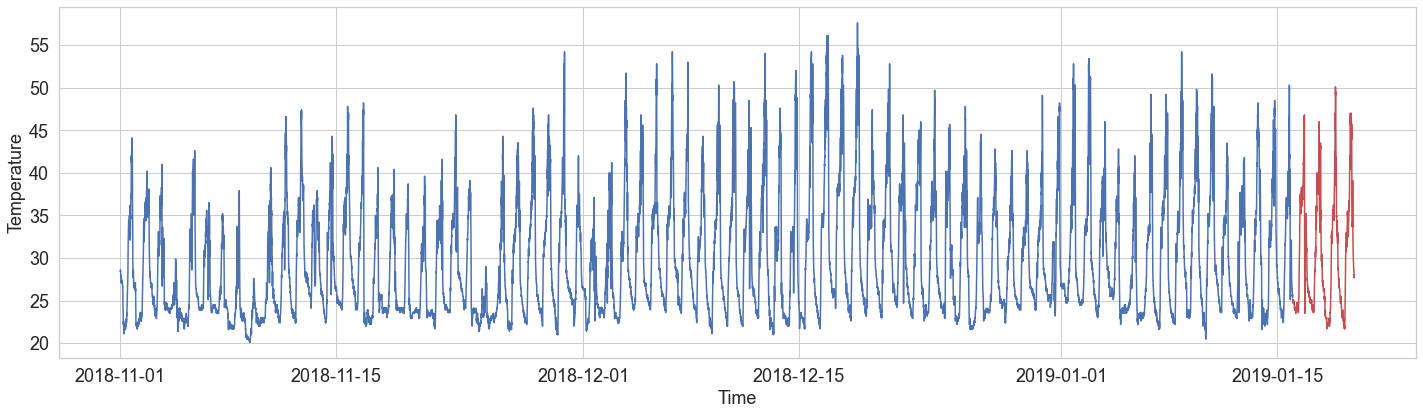

In [69]:
fig, ax1 = plt.subplots(1,1, figsize=(20, 6))
ax1.plot(slice_of_data.loc[split_date:test_date]['Temp_Mod'], label='Train')
ax1.plot(slice_of_data.loc[test_date:final_date]['Temp_Mod'], color='r', label='Test')
ax1.set_xlabel('Time', fontsize=18)
ax1.set_ylabel('Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/TempTrain.pdf', dpi=300)

##### **Create segments of data**

In [59]:
# How many timestamps in the past to make a single prediction
timesteps = 64
X_train_seg, y_train_seg = anm.split_sequences(X_train, feature_index=0, n_steps=timesteps)
X_test_seg, y_test_seg = anm.split_sequences(X_test, feature_index=0, n_steps=timesteps)
train_X, train_y = anm.split_sequences_multivariate(X_train, n_steps=64)
test_X, test_y = anm.split_sequences_multivariate(X_test, n_steps=64)

n_features, n_timesteps, n_samples  = X_train_seg.shape[-1], X_train_seg.shape[-2], X_train_seg.shape[0]
n_outputs_s, n_outputs_m = 1, train_X.shape[-1] 
n_predictions = 1
print('Number of Samples {} -> Number of timesteps {} -> Number of features {}'.format(n_samples, n_timesteps, n_features))

(21824, 64, 10) (21824,)
(1088, 64, 10) (1088,)
(21824, 64, 10) (21824, 10)
(1088, 64, 10) (1088, 10)
Number of Samples 21824 -> Number of timesteps 64 -> Number of features 10


#### **Create and fit LSTM model**

Since this is a regression problem, there is no accuracy

In [60]:
# define model
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(128, activation='linear'))
#model.add(Dropout(0.2))
model.add(Dense(n_outputs_s, activation='linear'))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 64)            19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 60,673
Trainable params: 60,673
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Hyper-parameters
BATCH_SIZE = 256
EPOCHS = 30
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)]

In [62]:
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x=X_train_seg, y=y_train_seg, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    callbacks=callbacks_list, validation_split=0.1, verbose=1)
# convert the history.history dict to a pandas DataFrame:     
history_df = pd.DataFrame(history.history) 

Epoch 1/30
77/77 [==============================] - 20s 147ms/step - loss: 0.0933 - val_loss: 0.0495
Epoch 2/30
77/77 [==============================] - 11s 136ms/step - loss: 0.0348 - val_loss: 0.0351
Epoch 3/30
77/77 [==============================] - 11s 138ms/step - loss: 0.0255 - val_loss: 0.0443
Epoch 4/30
77/77 [==============================] - 11s 141ms/step - loss: 0.0252 - val_loss: 0.0292
Epoch 5/30
77/77 [==============================] - 12s 150ms/step - loss: 0.0200 - val_loss: 0.0265
Epoch 6/30
77/77 [==============================] - 12s 156ms/step - loss: 0.0196 - val_loss: 0.0257
Epoch 7/30
77/77 [==============================] - 11s 146ms/step - loss: 0.0181 - val_loss: 0.0232
Epoch 8/30
77/77 [==============================] - 11s 142ms/step - loss: 0.0167 - val_loss: 0.0210
Epoch 9/30
77/77 [==============================] - 12s 150ms/step - loss: 0.0139 - val_loss: 0.0199
Epoch 10/30
77/77 [==============================] - 11s 146ms/step - loss: 0.0131 - val_lo

##### **Save and evaluate model**

We can see some spikes much bigger than the prediction, this spikes can be considered as anomalies, since the temperature went too far beyond what was expected.

**Now we have to chose a threshold**. We can take the minimum value of the largest ones, or consider 1 or 2 standar deviations away as the threshold. We can take the mean absolute error from the training test and set a threshold using 3 standard deviations away, the compare the mean absolute error in testing with this threshold.

In [70]:
name= '../Model/model_LSTM_E' + str(EPOCHS) + '_BZ' + str(BATCH_SIZE) + '_D' + str(0) + '_Res_' + resample_time
#anm.serialize_model(model, history_df, name= name)
#model=anm.load_model('../Model/model_LSTM_E'+str(EPOCHS)+'_BZ'+str(BATCH_SIZE)+'_D'+str(0)+'_Res_'+resample_time)
#history_df= pd.read_csv('../Model/model_LSTM_E'+str(EPOCHS)+'_BZ'+str(BATCH_SIZE)+'_D'+str(0)+'_Res_'+resample_time+'.csv', usecols=['val_loss', 'loss'])

In [72]:
#anm.plot_model_results(model, history_df, X_test_seg, y_test_seg, index=test_data.index[64:])

# create the list of difference between prediction and test data
abs_err_train, threshold = anm.get_abs_err(X_train_seg, y_train_seg, model, std=5, plot=True)
abs_err_test = anm.get_abs_err(X_test_seg, y_test_seg, model, plot=False)

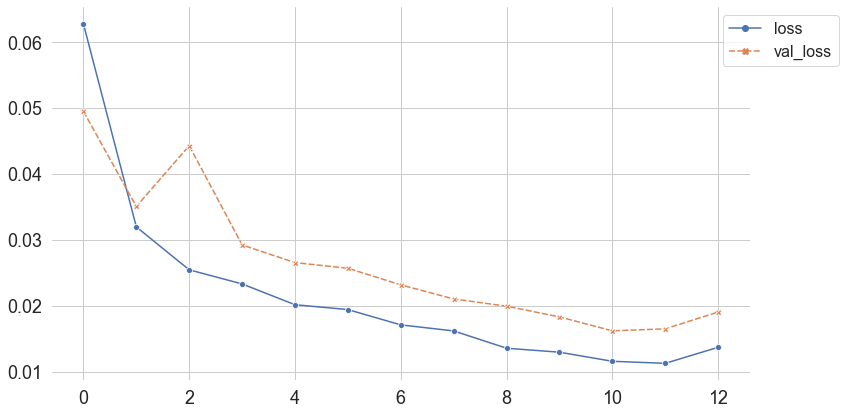

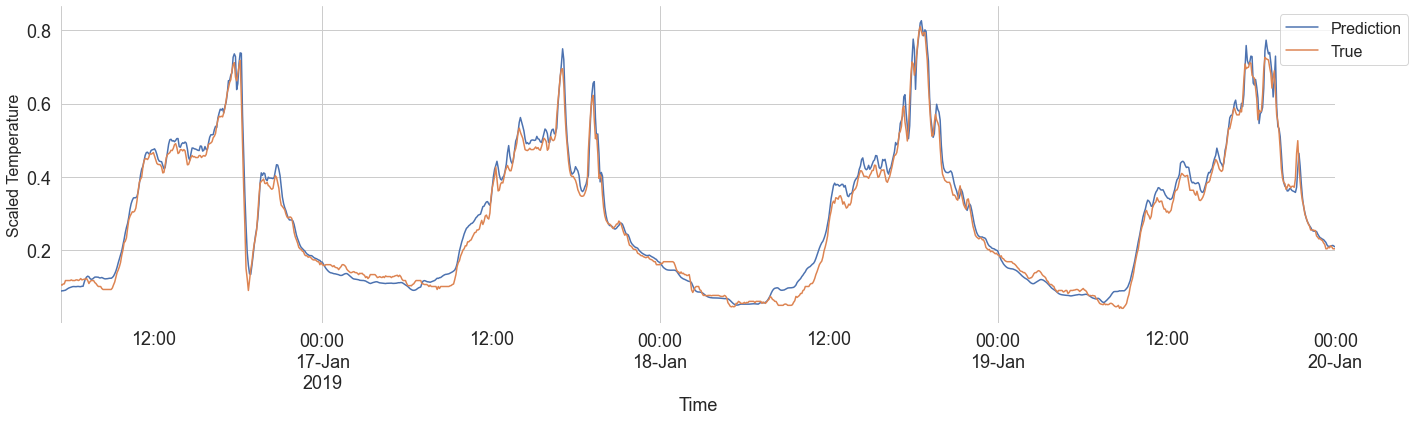

In [77]:
# Plot model results
X = X_test_seg
y = y_test_seg
index = test_data.index[64:]
prediction = model.predict(X)
if prediction.shape[-1] == 1:
    pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'], index=index)
else:
    pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1), y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'], index=index)

fig, ax1 = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=history_df[['loss','val_loss']], ax=ax1, markers=True)
#plt.title('Validation and Training Loss')
remove_chart_borders(ax1)
ax1.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.tight_layout()
fig.savefig('../images/LossLSTM.pdf', dpi=300)

fig, ax1 = plt.subplots(1, 1, figsize=(20,6))
pred_df.plot(ax=ax1)
#plt.title('Prediction and Truth (Scaled)')
remove_chart_borders(ax1)
ax1.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Scaled Temperature', fontsize=16)
plt.tight_layout()
fig.savefig('../images/PredAndTruthLSTMAnomaly.pdf', dpi=300)

In [40]:
# run the other methods
data, anomaly_Iforest = anm.isolation_forest(data, n_estimators=50, outliers_fraction=0.01, scaler=MinMaxScaler())
data, anomaly_svm = anm.oneClass_SVM(data, nu=0.95, outliers_fraction=0.01, scaler=MinMaxScaler())
#LSTM
predictions_df, anomalies_LSTM = anm.get_anomaly_and_pred(model, X_test_seg, y_test_seg, threshold, test_data)
data['anomaly_LSTM'] = anomalies_LSTM
data['anomaly_LSTM'] = data['anomaly_LSTM'].fillna(0) # Fill the rest with 0

print(anomaly_Iforest.describe().transpose())
print(anomaly_svm.describe().transpose())
print(data[data['anomaly_LSTM']==1][['Temp_Mod']].describe().transpose())

          count    mean  std   min   25%    50%   75%   max
Temp_Mod  230.0  48.879  2.5  45.3  46.8  48.45  50.3  55.9
          count     mean      std   min   25%      50%      75%   max
Temp_Mod  214.0  38.3009  12.1753  21.7  26.1  40.2167  49.7917  57.1
          count     mean     std   min      25%      50%      75%    max
Temp_Mod    8.0  39.8646  6.5024  25.7  37.5583  42.2167  43.4167  45.95


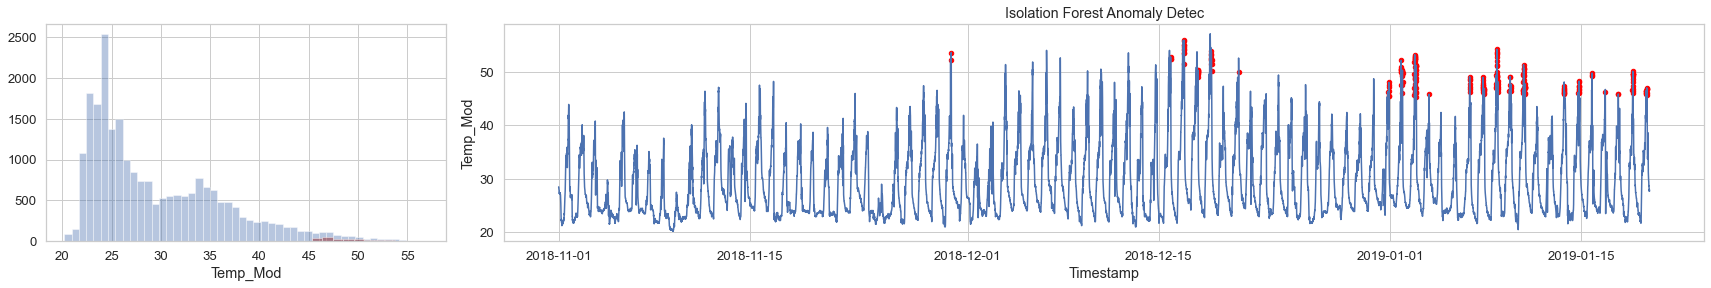

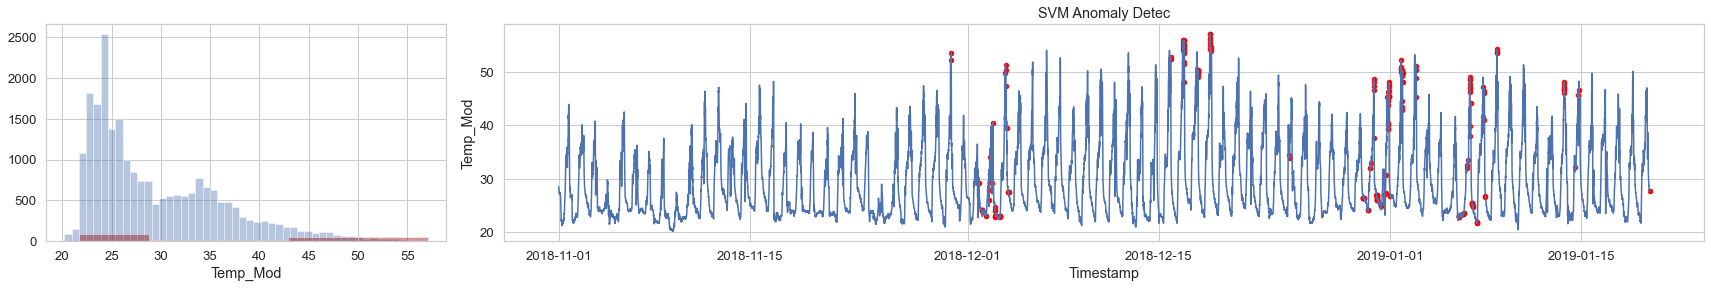

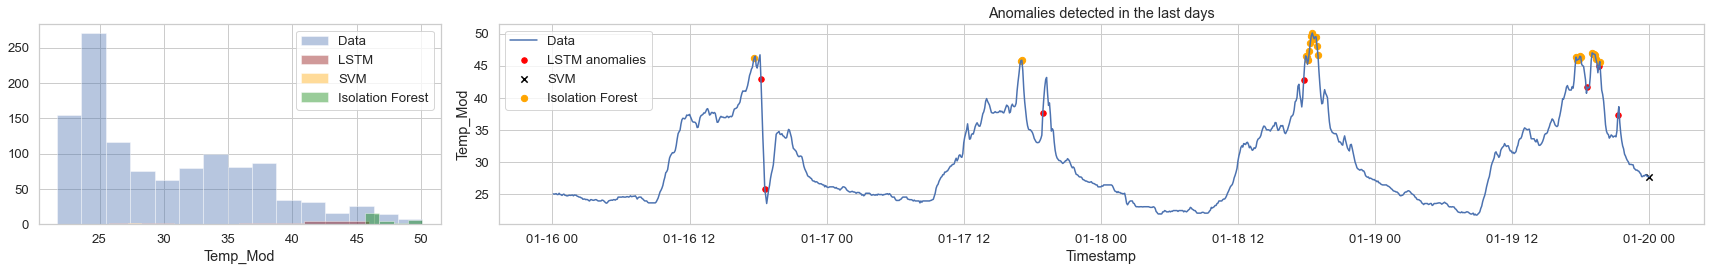

In [41]:
anm.plot_anomalies_model(data, test_date, anomaly_Iforest, select='others')
plt.title('Isolation Forest Anomaly Detec')
anm.plot_anomalies_model(data, test_date, anomaly_svm, select='others')
plt.title('SVM Anomaly Detec')
#plot_anomalies_model(data, test_date, anomalies_LSTM, select='LSTM')
anm.plot_anomalies_model(data, test_date, anomalies_LSTM, select='all', anomalies_svm=anomaly_svm, anomalies_forest=anomaly_Iforest)

Isolation Forest is much more faster finding anomalies than Gaussian and detects distributed anomalies. Didn't detected outliers with small values either. SVM gives a result similar to Isolation forest, but with more anomalies. Slighly better at finding anomalies with smaller values.<br>

**We can see how LSTM catches abrupt changes, for example, in 01-16, at around 6:00 Pm there was an abrupt fall and the algorithm was capable of catching it. SVM was also capable of it. LSTM also catches to high spikes and spikes in places where there should'n be any, like in the final part of the data.**

After running the algorithms, we can see that is possible to apply the concept of wisdom of the crowds since the algorithms have some results in common.

- Still, this is vulnerable to false positives since we are doing unsupervised anomaly detection.

- Another possible solution is to forecast some values and then look for anomalies comparing the forecast with the actual values and some threshold. The same trained model can be used to forecast but we need to see how good is at forecasting and how many values in the future we can predict with some minimal precision.<br> The idea is to predict some values, check for anomalies comparing the error of prediction with a threshold, then take the next set of values and do the same, but instead of forecast in a forecasted value, do it with the real values.

- Other possible solution, maybe more accurate, is to create a supervised problem creating 2 classes, anomaly and normal (clustering techniques). Stablish all the data we know is correct as normal data and create some anomalies based on what whe think an anomaly would look like. Then we would have a classification problem, that can be solved either using LSTM, DNN or CNN+WSN.

- Another way to see the anomalies is converting the data to another domain, like frequency domain using Fourier Transform, or time-freq using Wavelets.

- Use another method of forecasting like ARIMA

## Exploring anomalies in multiple sensors

(21824, 64, 10) (21824,)
(1088, 64, 10) (1088,)
Number of Samples 21824 -> Number of timesteps 64 -> Number of features 10
Epoch 00016: early stopping
          count   mean     std   min   25%   50%    75%   max
Temp_Mod   10.0  36.48  4.8463  28.0  33.8  37.6  40.05  42.8


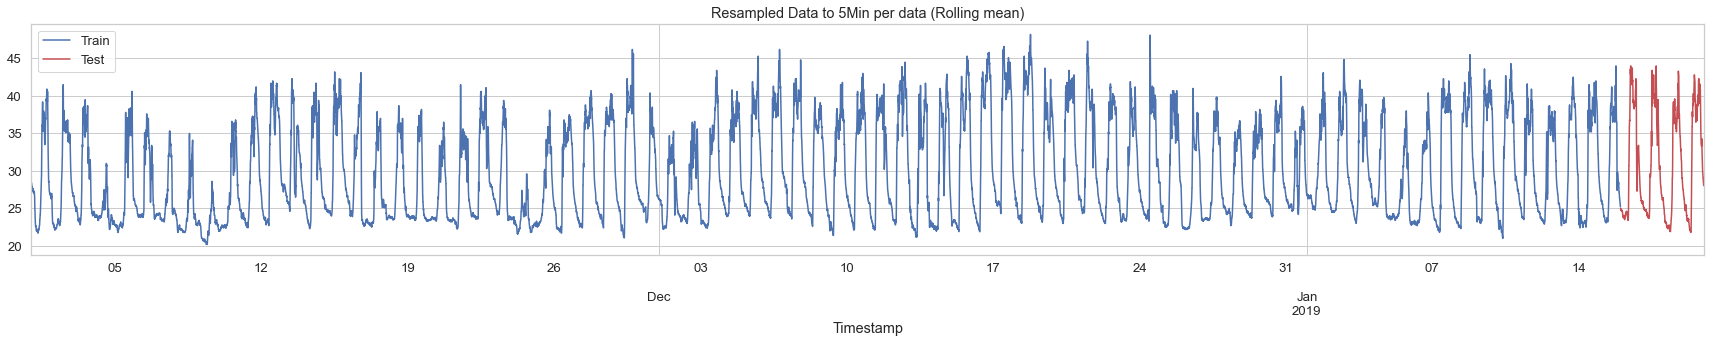

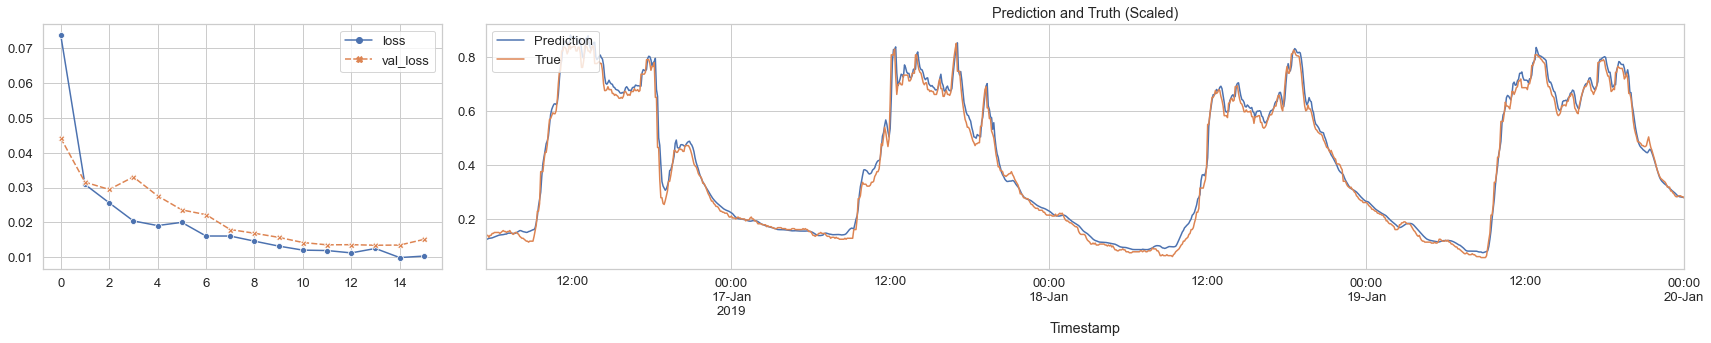

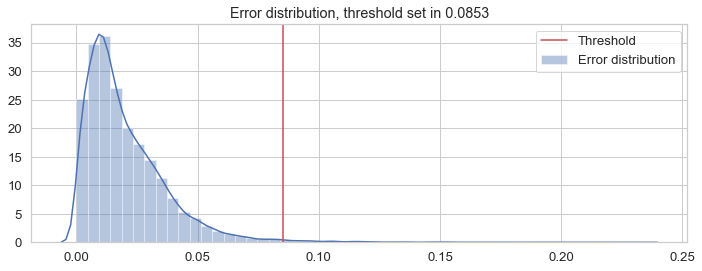

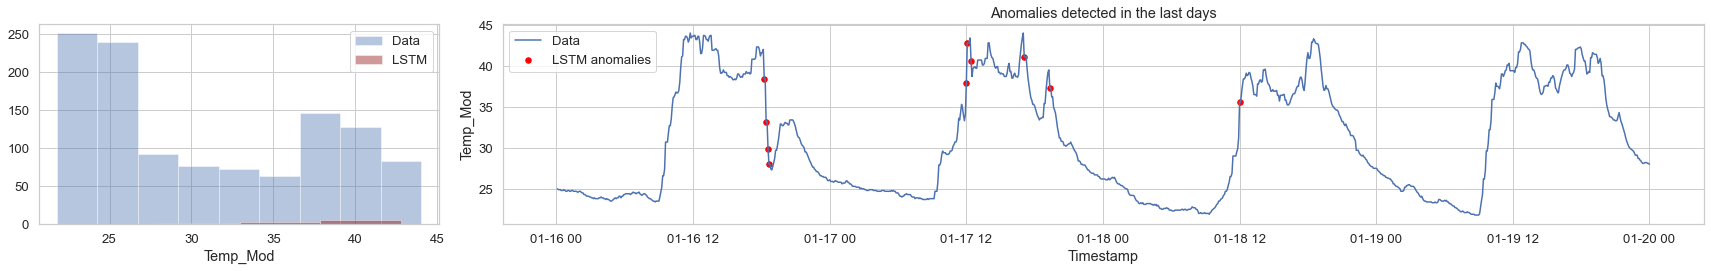

In [52]:
# Here taking only one module
sensor1 = df[df['Module']== '34.B2.9F.A9'].dropna(axis=1, how='all')

outliers_fraction = 0.01
final_date='2019-01-20 00:00:05'
split_date = '2018-11-01 00:00:05'
test_date = '2019-01-16 00:00:05'
resample_time = '5Min'

# Splitting by date, saving a part for testing
data, train_data, test_data, X_train, X_test, y_train, y_test, scaler = \
anm.create_train_test(sensor1, final_date=final_date, split_date=split_date, test_date=test_date,
                      resample_time=resample_time, figsize=(24,5), scaler=MinMaxScaler())

# How many timestamps in the past to make a single prediction
timesteps = 64
X_train_seg, y_train_seg = anm.split_sequences(X_train, feature_index=0, n_steps=timesteps)
X_test_seg, y_test_seg = anm.split_sequences(X_test, feature_index=0, n_steps=timesteps)

n_features, n_timesteps, n_samples  = X_train_seg.shape[-1], X_train_seg.shape[-2], X_train_seg.shape[0]
n_outputs_s, n_outputs_m = 1, train_X.shape[-1] 
n_predictions = 1
print('Number of Samples {} -> Number of timesteps {} -> Number of features {}'.format(n_samples, n_timesteps, n_features))

# define model
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(128, activation='linear'))
#model.add(Dropout(0.2))
model.add(Dense(n_outputs_s, activation='linear'))
model.compile(optimizer='adam', loss='mae')
#model.summary()

# Hyper-parameters
BATCH_SIZE = 256
EPOCHS = 30
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)]

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x=X_train_seg, y=y_train_seg, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    callbacks=callbacks_list, validation_split=0.1, verbose=0)

anm.plot_model_results(model, history_df, X_test_seg, y_test_seg, index=test_data.index[64:])

# create the list of difference between prediction and test data
abs_err_train, threshold = anm.get_abs_err(X_train_seg, y_train_seg, model, std=5, plot=True)
abs_err_test = anm.get_abs_err(X_test_seg, y_test_seg, model, plot=False)

predictions_df, anomalies_LSTM = anm.get_anomaly_and_pred(model, X_test_seg, y_test_seg, threshold, test_data)
data['anomaly_LSTM'] = anomalies_LSTM
data['anomaly_LSTM'] = data['anomaly_LSTM'].fillna(0) # Fill the rest with 0
print(data[data['anomaly_LSTM']==1][['Temp_Mod']].describe().transpose())
anm.plot_anomalies_model(data, test_date, anomalies_LSTM, select='LSTM', anomalies_svm=None, anomalies_forest=None)
plt.tight_layout()

(21824, 64, 9) (21824,)
(1088, 64, 9) (1088,)
Number of Samples 21824 -> Number of timesteps 64 -> Number of features 9
Epoch 00008: early stopping
          count     mean     std   min   25%   50%      75%   max
Temp_Mod   38.0  28.4645  5.3118  21.8  23.5  28.1  30.9125  39.5


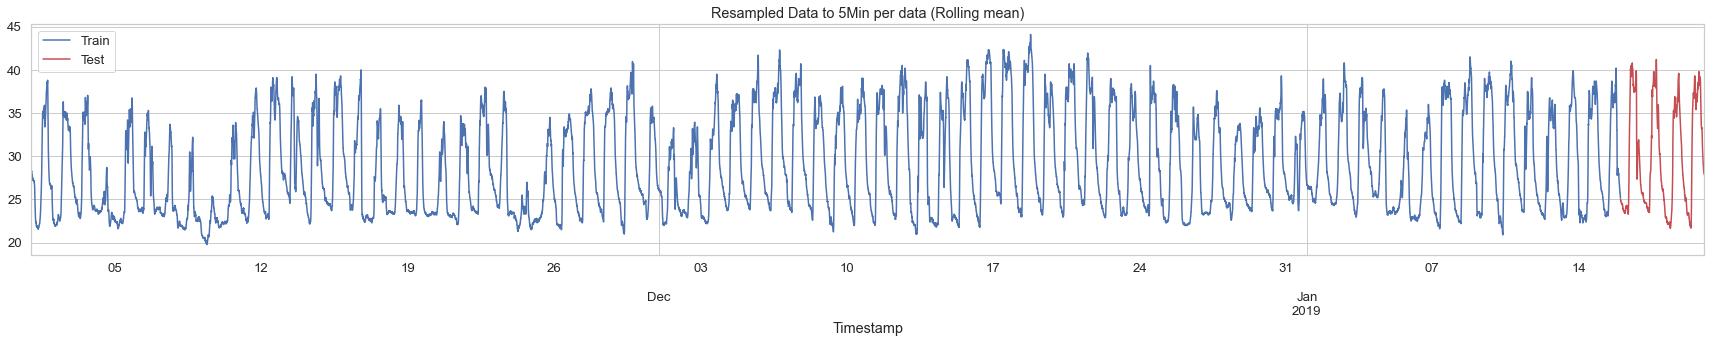

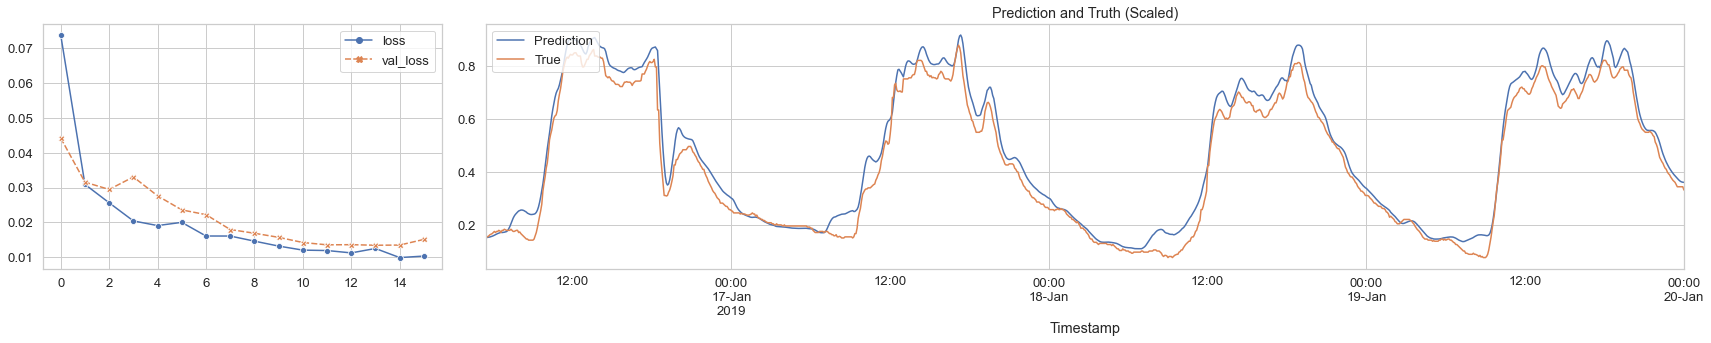

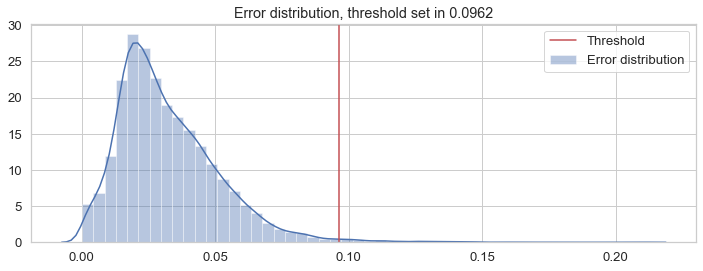

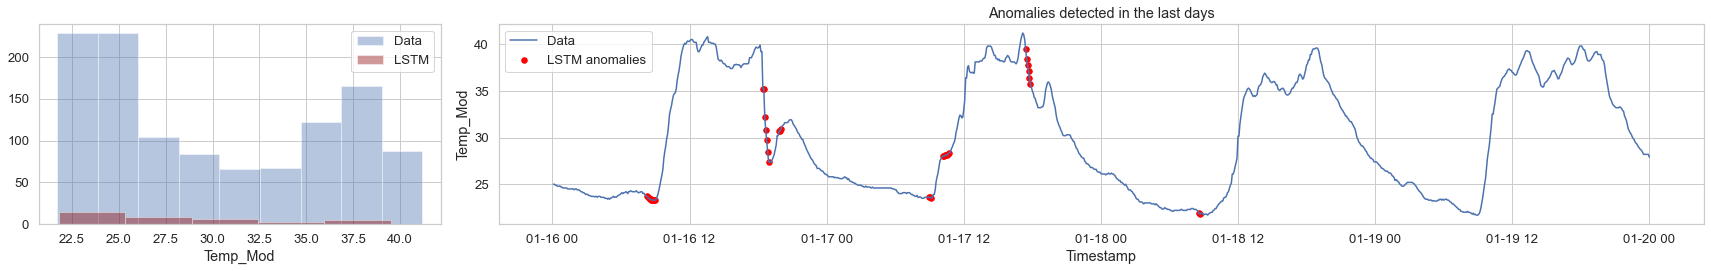

In [54]:
sensor2 = df[df['Module']== 'A7.CB.0A.C0'].dropna(axis=1, how='all')

# Splitting by date, saving a part for testing
data, train_data, test_data, X_train, X_test, y_train, y_test, scaler = \
anm.create_train_test(sensor2, final_date=final_date, split_date=split_date, test_date=test_date,
                      resample_time=resample_time, figsize=(24,5), scaler=MinMaxScaler())

# How many timestamps in the past to make a single prediction
timesteps = 64
X_train_seg, y_train_seg = anm.split_sequences(X_train, feature_index=0, n_steps=timesteps)
X_test_seg, y_test_seg = anm.split_sequences(X_test, feature_index=0, n_steps=timesteps)

n_features, n_timesteps, n_samples  = X_train_seg.shape[-1], X_train_seg.shape[-2], X_train_seg.shape[0]
n_outputs_s, n_outputs_m = 1, train_X.shape[-1] 
n_predictions = 1
print('Number of Samples {} -> Number of timesteps {} -> Number of features {}'.format(n_samples, n_timesteps, n_features))

# define model
model = tf.keras.Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(128, activation='linear'))
#model.add(Dropout(0.2))
model.add(Dense(n_outputs_s, activation='linear'))
model.compile(optimizer='adam', loss='mae')
#model.summary()

# Hyper-parameters
BATCH_SIZE = 256
EPOCHS = 30
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)]

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x=X_train_seg, y=y_train_seg, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    callbacks=callbacks_list, validation_split=0.1, verbose=0)

anm.plot_model_results(model, history_df, X_test_seg, y_test_seg, index=test_data.index[64:])

# create the list of difference between prediction and test data
abs_err_train, threshold = anm.get_abs_err(X_train_seg, y_train_seg, model, std=5, plot=True)
abs_err_test = anm.get_abs_err(X_test_seg, y_test_seg, model, plot=False)

predictions_df, anomalies_LSTM = anm.get_anomaly_and_pred(model, X_test_seg, y_test_seg, threshold, test_data)
data['anomaly_LSTM'] = anomalies_LSTM
data['anomaly_LSTM'] = data['anomaly_LSTM'].fillna(0) # Fill the rest with 0
print(data[data['anomaly_LSTM']==1][['Temp_Mod']].describe().transpose())
anm.plot_anomalies_model(data, test_date, anomalies_LSTM, select='LSTM', anomalies_svm=None, anomalies_forest=None)
plt.tight_layout()

### Exploring smoothing techniques and detecting anomalies

In [211]:
slice_of_data = df[df['Module']== '00.57.FE.0E'].dropna(axis=1, how='all')[['Temp_Mod']]
slice_of_data = slice_of_data.resample('60Min').mean()
slice_of_data = slice_of_data.fillna(slice_of_data.bfill())

In [212]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [213]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(slice_of_data.Temp_Mod, 24) # prediction for the last observed day (past 24 hours)

28.484117954199224

In [214]:
def plotMovingAverage(series, window=4, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=5)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [114]:
# Let's take a little zoom to see better the moving average
# smothing by 24 hours
serie = slice_of_data[['Temp_Mod']]['2019-04':'2019-06']
plotMovingAverage(serie, 24, plot_intervals=True, plot_anomalies=True) # Smothing by 24 hours

NameError: name 'plotMovingAverage' is not defined

Now, we can see that using a moving average technique detects high and low values as anomalies, but abrupt changes and missing data past wothout notice.

### Let's try LSTM with Autoencoders

In [117]:
# Here taking only one module
slice_of_data = df[df['Module']== '00.57.FE.0E'].dropna(axis=1, how='all')
#slice_of_data.head()

final_date='2019-01-20 00:00:05'
split_date = '2018-11-01 00:00:05'
test_date = '2019-01-16 00:00:05'
resample_time = '5Min'

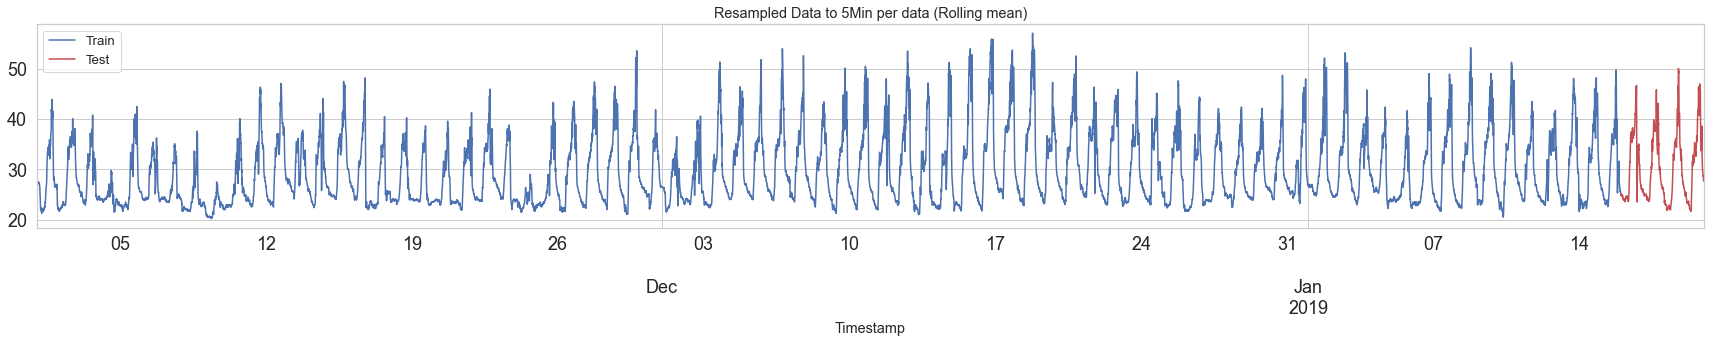

In [118]:
# Splitting by date, saving a part for testing
data, train_data, test_data, X_train, X_test, y_train, y_test, scaler = anm.create_train_test(slice_of_data, final_date=final_date, split_date=split_date, test_date=test_date,
                                                                                              resample_time=resample_time, figsize=(24,5), scaler=MinMaxScaler())

In [119]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [120]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data[['Temp_Mod']])

train_data['Temp_Mod'] = scaler.transform(train_data[['Temp_Mod']])
test_data['Temp_Mod'] = scaler.transform(test_data[['Temp_Mod']])

In [121]:
time_steps=64
X_train, y_train = create_sequences(train_data[['Temp_Mod']], train_data.Temp_Mod, time_steps)
X_test, y_test = create_sequences(test_data[['Temp_Mod']], test_data.Temp_Mod, time_steps)
print(X_train.shape, X_test.shape)

(21824, 64, 1) (1088, 64, 1)


In [122]:
num_features = X_train.shape[2]

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, input_shape=(time_steps, num_features)),
    Dropout(0.2),
    RepeatVector(time_steps), # replicates features from outputs (30 times)
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    # Time distributed layer to get an output with right shape
    TimeDistributed(Dense(num_features))
])
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [124]:
callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[callback],
    shuffle=False
)

Epoch 1/100
614/614 [==============================] - 65s 93ms/step - loss: 0.0442 - val_loss: 0.0223
Epoch 2/100
614/614 [==============================] - 60s 97ms/step - loss: 0.0214 - val_loss: 0.0285
Epoch 3/100
614/614 [==============================] - 60s 97ms/step - loss: 0.0178 - val_loss: 0.0203
Epoch 4/100
614/614 [==============================] - 60s 99ms/step - loss: 0.0150 - val_loss: 0.0134
Epoch 5/100
614/614 [==============================] - 60s 98ms/step - loss: 0.0141 - val_loss: 0.0127
Epoch 6/100
614/614 [==============================] - 62s 101ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 7/100
614/614 [==============================] - 63s 102ms/step - loss: 0.0130 - val_loss: 0.0259
Epoch 8/100
614/614 [==============================] - 61s 100ms/step - loss: 0.0141 - val_loss: 0.0147


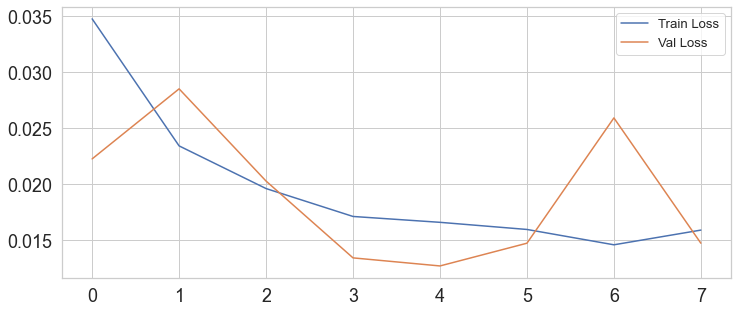

In [125]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

In [126]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

model.evaluate(X_test, y_test, verbose=False)

0.013084041886031628

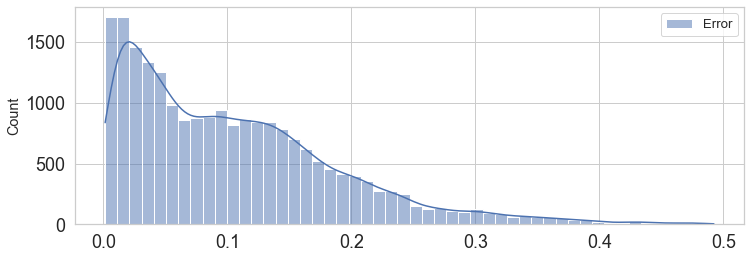

In [127]:
plt.figure(figsize=(12,4))
sns.histplot(train_mae_loss, bins=50, kde=True)

In [149]:
threshold = 0.28

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [150]:
# values classified as anomalies are the ones that exceed the threshold
test_score_df = pd.DataFrame(test_data[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Temp_Mod'] = test_data[time_steps:].Temp_Mod

In [151]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Temp_Mod,VBus,hour,day,month,week,weekday,daylight,loss,threshold,anomaly
Timestamp,,,,,,,,,,,
2019-01-16 18:35:00,0.1491,3.4465,18.0,16.0,1.0,3.0,2.0,1.0,0.3078,0.28,True
2019-01-16 18:40:00,0.1220,3.4583,18.0,16.0,1.0,3.0,2.0,1.0,0.4227,0.28,True
2019-01-16 18:45:00,0.0894,3.4540,18.0,16.0,1.0,3.0,2.0,1.0,0.4026,0.28,True
2019-01-16 18:50:00,0.1183,3.4610,18.0,16.0,1.0,3.0,2.0,1.0,0.4336,0.28,True
2019-01-16 18:55:00,0.1463,3.4670,18.0,16.0,1.0,3.0,2.0,1.0,0.3747,0.28,True


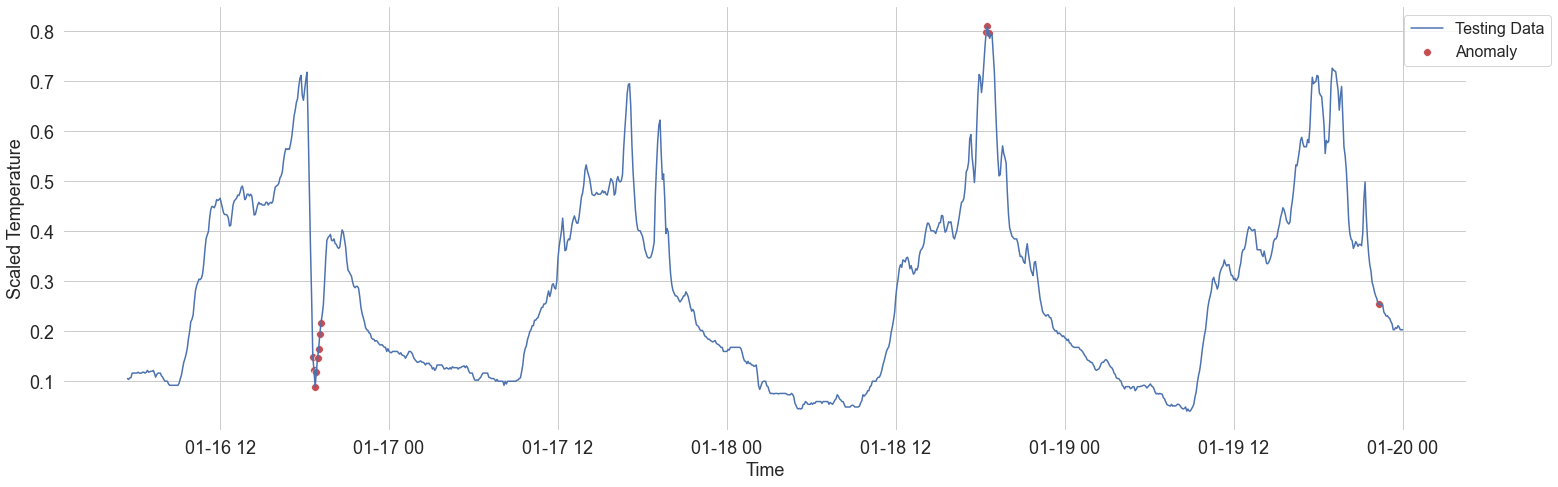

In [158]:
fig, ax1 = plt.subplots(1, 1, figsize=(22,7))
sns.lineplot(x=test_data[time_steps:].index, y=test_data[time_steps:].Temp_Mod, ax=ax1, label='Testing Data')
sns.scatterplot(x=anomalies.index, y=anomalies.Temp_Mod, color='r', ax=ax1, label='Anomaly', s=60)
remove_chart_borders(ax1)
ax1.legend(fontsize=16, bbox_to_anchor=(0.95, 1), loc='upper left')
ax1.set_xlabel('Time', fontsize=18)
ax1.set_ylabel('Scaled Temperature', fontsize=18)
plt.tight_layout()
fig.savefig('../images/LSTMAnomalyDetected.pdf', dpi=300)

**The algorith only recognizes the hard fall between 01-16 and 01-17, but did't catch the rest of the anomalies. We could say it's more robust to false positives, it all depends of what should be considered as abnormal, definetly the hard fall is one, another could be the double spikes between 01-17 and 01-18 and the final spike close to 01-20**